# Time-dependent PDEs in FEniCS

## Time is crucial for many processes

In [1]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/CCmTY0PKGDs" frameborder="0" allowfullscreen></iframe>')

## The heat equation is the "Hello world" example of a time-dependent PDE

We will solve the simplest extension of the Poisson problem into
the time domain, the **heat equation**:

$$
\frac{\partial u}{\partial t} - D u_{xx} = f  \qquad \text{ for } x \in \Omega \text{ and for } t \in [0, T], \\
u = g  \qquad \text{ for } x \in \partial \Omega \text{ and } t \in [0, T], \\
u = u^0 \qquad \text{ for } x \in \Omega \text{ and } t = 0.
$$

with $D \in \mathbb R$. $\Omega$ denotes the spatial domain and $\partial \Omega$ the domain boundary. For example for $\Omega = [-L, L]$, the boundary $\partial \Omega$ consists of the two points $-L$ and $L$. We start the simulation at time $t=0$ until the final time $T$.


The solution $u = u(x, t)$, the right-hand side $f = f (x, t)$ and the
boundary value $g = g(x, t)$ may vary in space $(x)$
and time (t). The initial value $u_0$ is a function of space only.

Let's see how a 2D solution of this problem looks like:

In [2]:
## An example solution in 2D
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/TvlIfSlLB0c" frameborder="0" allowfullscreen></iframe>')

**Question**: Which kind of initial/boundary conditions were used in the above simulation?

## Time-discretization of the heat equation

FEniCS cannot direct solve time-dependent equations. We therefore must approximate the time-derivative $\frac{\partial u}{\partial t}$, that is discretise in time. This will lead to a sequence of non-time dependent PDEs, which we can solve with FEniCS. 


Our goal is to compute the solution at a set of discrete time-levels $0 = t^0 < t^1 < ... < T^N = T$. 
The variables at the n'th time-levels will denoted with a superscript $n$:

$$ u^n \approx u(t^n) \\
f^n = f(t^n)
$$

We discretize in time using the **implicit Euler** method.

$$ \frac{\partial u}{\partial t} (t^n) \approx \frac{u^n - u^{n-1}}{\Delta t} $$
This leads to the semi-discretization of the heat equation ("semi"-discretisation because we have discretised in time, but not yet in space):
$$
u^n - u^{n-1} - u^n_{xx} = \Delta t f_n 
$$


### Time stepping algorithm for the heat equation

1. Start with $u^0$ and choose a timestep ∆t > 0.
2. For $n = 1, 2, ...$ solve for $u^n$: 
 
   $u^n − \Delta t u^n_{xx} = u^{n-1} + \Delta t f^n$

## Variational problem for the heat equation

To obtain the fully-discretised system, we derive the variational formulation of the semi-discretised system:

Find $u^n, n=1, ..., N$ such that 
$$
 a(u^n, v) = L^n(v)  \quad \text{ for all } v
$$
where 
$$
  a(u^n, v) = \int_\Omega u^nv + \Delta t u_x v_x \text{d}x\\
  L^n(v) = \int_\Omega u^{n-1}v + \Delta t f^nv \text{d}x
$$
Note that the bilinear form $a(u, v)$ is constant while the linear
form $L^n$ depends on $n$.

## Detailed time-stepping algorithm for the heat equation

The following sceleton shows how to solve a time-dependent problem in FEniCS:

* Define the mesh, functions-spaces and Dirichlet boundary conditions
* Compute $u_0$ as the projection of the given initial value
* Define the forms $a$ and $L$
* Set $t$ to $\Delta t$
* **while $t < T$ do**
    * Apply the boundary condition
    * Solve the $A = L$ for $U$ and store in $u_1$
    * Set $t$ to $t + \Delta t$
    * Set $u_0$ to $u_1$ (get ready for next step)
* **end while**

## Some implementation tips - let's started with setting up a basic FEniCS environment

In [4]:
%matplotlib inline
from fenics import *
import pylab
#parameters['plotting_backend'] = 'matplotlib'

mesh = UnitIntervalMesh(10)
V = FunctionSpace(mesh, "CG", 1)

## Handling time-dependent expressions

We need to define a time-dependent expression for the boundary value:

In [6]:
beta = 1.2
g = Expression("1-beta*t", beta=beta , t=0, degree=2)

# parameter values can be modified 
g.beta = 1.
g.t = 0.1

Updating parameter values:

## Projection and interpolation

Now `g` is a `fenics.Expression`, which does not depend on the mesh. Our unknown will be a `fenics.Function`, which is something living on a particular mesh, so to set its initial value we need to project the Expression g:

In [7]:
u0 = project(g, V)

print("g is a: ", type(g))
print("u0 is a: ", type(u0))


g is a:  <class 'dolfin.functions.expression.CompiledExpression'>
u0 is a:  <class 'dolfin.functions.function.Function'>


## Implementing the variational problem

In [8]:
# The time-step
dt = 0.3

# Initial condition
beta = 1.2
g = Expression("1-beta*t", beta=beta , t=0, degree=2)
g.t=0
u0 = project(g, V)


# Define a variable to store the solution at the previous time-step
u1 = Function(V)

# Define a source term
f = Constant(0) # Expression("x[0]+1", degree=1)

# Define the Dirichlet boundary condition
bc = DirichletBC (V, g, "on_boundary")

# Code the variational formulation
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt* inner(grad(u), grad(v))*dx
#a = u*v*dx + dt* u.dx(0) * v.dx(0)*dx
L = u0*v*dx + dt*f*v*dx

## Implementing the time-stepping loop

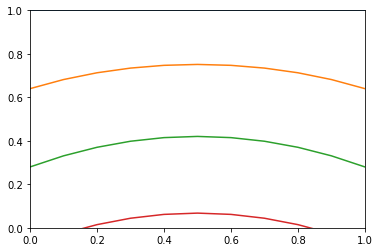

In [7]:
# Implement the time-oop
T = 1.0
t = 0
    
while t <= T:
    # Update the time-level of the boundary expression
    g.t = t
    
    # Solve the linear system
    solve(a == L, u1, [bc])
    
    # Get ready for the next time-step
    t += dt
    u0.assign(u1)
    
    # Plot the solution
    p = plot(u0, label='t={}'.format(t))
    p[0].axes.set_xlim([0, 1])
    p[0].axes.set_ylim([0, 1])
    #pylab.legend()

## A possible performance boost - a closer look at solve
The above code works, but a small modification can improve its performance if necessary. For linear problems, this code Python code
```python
solve(a == L, u, bcs)
```
is equivalent to this (see video on FEM for explanation of the details)
```python 
# Assembling a bilinear form yields a matrix
A = assemble(a)
# Assembling a linear form yields a vector
b = assemble(L)
# Applying boundary condition info to system
for bc in bcs:
    bc.apply(A , b)
    # Solve the linear system of equations Ax = b
    solve (A, u.vector(), b)
```

Because ``a`` does not change, we could avoid the call to ``assemble(a)`` at every time step by pulling it outside of the loop.

## The cable equations

The standard cable equation is a reaction-diffusion equation given by
$$
\frac{\partial u}{\partial t}  = \sigma u_{xx} + f(u, s)
$$
where $f(u, s)$ is a reaction term describing ionic fluxes across
the membrane.
* A linear $f(u)$ describes passive conductance through a leaky cable (dendrites).
* A cubic $f(u)$ gives the bistable equation with a propagating activation front.
* In general $f(u, s)$, where s is a vector describing the state of the cell membrane, typically governed by a system of ODEs.

## Exercise 1: The cable equation

Solve the linear, bistable cable equation on an interval $\Omega=[-L, L]$ in FEniCS 
$$
\frac{\partial u}{\partial t} = \sigma u_{xx} + f(u) \quad \text{ for } -L < x < L, \\
u_x = 0 \quad \text{ for } x = -L \text{ and } x = L,
$$
with 
* $f(u) = Au$,
* $A = -0.1$,
* $\sigma = 1.0$,
* $L = 100$.

Implement an implicit Euler time-stepping scheme and solve the problem from $t=0$ to $T=250$ with a timestep of $dt=2.5$. Use as initial condition

$$
\frac{1}{2} (1-\tanh(\sqrt{-A/8\sigma)}(x+0.75L)))
$$
Create a plot of the solution on every 10th time-step. What happens if you change the value and sign of A? To improve the performance of your solver, try making it ``assemble(a)`` only once.

## Exercise 1 solution

Code doing this is below.

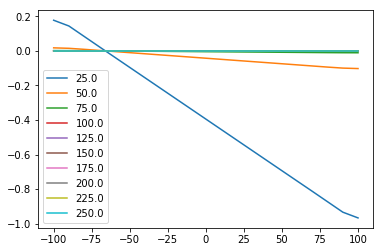

In [16]:
mesh = IntervalMesh(20, -100, 100)

V = FunctionSpace(mesh, "CG",  1)
u = TrialFunction(V)
v = TestFunction(V)

t = 0
T = 250
dt = 2.5
sigma = Constant(1.0)
A = -0.1

a = u*v*dx + dt* sigma* inner(grad(u), grad(v))*dx - dt * A * u * v * dx


e = Expression("0.5 * (1 - tanh(sqrt(-A/8*sigma))*(x[0] + 0.75*L))",
              A=A, sigma=sigma, L=100, degree=3)
u0 = interpolate(e, V)

L = u0*v*dx #+ dt*f*v*dx
u1 = Function(V)

n_timesteps = 0
while t <= T:
    n_timesteps += 1
    t += dt
    solve(a == L, u1)
    u0.assign(u1)
    if n_timesteps % 10 == 0:
        plot(u0, label=t)
    
pylab.legend()


## Exercise 2: Forward or backward?

Above, we discretized in time using the **implicit Euler** method, meaning that we replaced $ \frac{\partial u}{\partial t} (t^n)$ by $\frac{u^n - u^{n-1}}{\Delta t} $. This is also called the **backward** Euler method because we are approximating a derivative by a difference *backwards* in time.

We could also have used the **forward** or **explicit Euler** method by approximating $ \frac{\partial u}{\partial t} (t^n)$ by $\frac{u^{n+1} - u^n}{\Delta t} $. Note that now the difference is going *forwards* in time instead. Take the heat equation $$\frac {\partial u} {\partial t} = Du_{xx}$$ and discretize it using both methods. What does the resulting systems of equations look like? Why do you think one is called explicit and the other implicit?

Next, let us try to compare the two. Choose initial conditions and Dirichlet boundary conditions so that the exact solution becomes $u_e = \text{exp}(-t) \text{ sin}(x)$. Then, using a timestep of $\Delta t$ = 0.1, derive the weak formulation and solve using first a backward Euler discretization, then a forward Euler discretization. Plot the computed solution alongside the exact solution, or compute the error using `dolfin.errornorm(u_exact, u)`. Which time discretization would you prefer?

## Exercise 2 solution

With implicit Euler, the weak form becomes

$\int u^n v + D \Delta t \: u^n_x v_x = \int u^{n-1} v$ 

With explicit Euler, it is

$\int u^n v = \int u^{n-1} v - D \Delta t \: u^{n-1}_x v_x $ 

So in a way, in the latter case the resulting system of equations is basically $u^n = $ something known, so you don't really need to solve an equation for $u^n$ at all - it is **explicitly** given. The below code solves using explicit Euler. (Uncomment the two lines starting with a, L for implicit Euler.) This results in numerical artifacts and huge oscillations when the timestep is too big. Backward Euler may also be inaccurate, but is guaranteed to be stable (for this problem, at least), so is in general preferrable. Of course, that comes at the cost of being harder to compute, so in applications where performance is the most important, it might conceivably be better to use explicit Euler.

Calling FFC just-in-time (JIT) compiler, this may take some time.
The error is 17644418439030966845440.0000


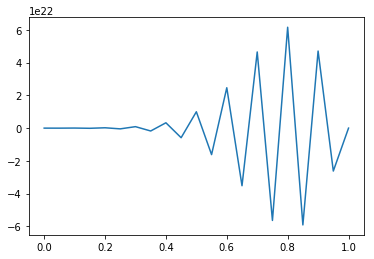

In [14]:
mesh = UnitIntervalMesh(20)
V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)
u_prev = Function(V)

u_exact = Expression("exp(-t) * sin(x[0])", degree=3, t=0)
u_prev = interpolate(u_exact, V)  # intital conditions

dt = 0.1
T = 1.0

D = Constant(1)

## explicit
a = u * v * dx
L = u_prev * v * dx - dt * u_prev.dx(0) * v.dx(0) * dx


## implicit 
# a = u * v * dx + dt * D * u.dx(0) * v.dx(0) * dx
# L = u_prev * v * dx


bcs = [DirichletBC(V, u_exact, "on_boundary")]

u = Function(V)
t = 0
while t <= T:
    t += dt
    u_exact.t = t
    solve(a==L, u, bcs)
    u_prev.assign(u)
    
plot(u)

e = errornorm(u, u_exact, "l2")

print("The error is {:.4f}".format(e))

## Exercise 3: 2D heat equation
(This exercise may be challenging without knowledge of vector calculus. Feel free to skip it.)

The heat equation can be extended to a 2D domain in the following way:
$$\frac{\partial u}{\partial t} - D \text{ div grad } u = f$$

Here, $\text{ grad }$ means the gradient (vector of $x$ and $y$ derivatives), and $\text{ div }$ means the divergence (sum of $x$ and $y$ derivatives).

To derive its weak formulation, you will need to generalize integration by parts to 2D. The relevant formula is:

$$\int_\Omega \psi \text{ div grad } \phi = - \int_\Omega \text{grad } \psi \cdot \text{ grad } \phi  + \text{ boundary term}$$ 

Use this to derive the weak formulation of the 2D heat equation. Then solve the heat equation on a unit square with the Dirichlet boundary condition $u = x(1-x)$ on the entire boundary, and the initial condition $u=0$. Some FEniCS commands you may need include the following:

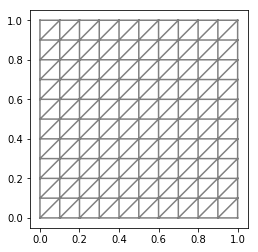

In [9]:
mesh = UnitSquareMesh(10, 10)
plot(mesh)
# to compute the inner product of vectors a, b, use inner(a, b)

## Exercise 4 solution:



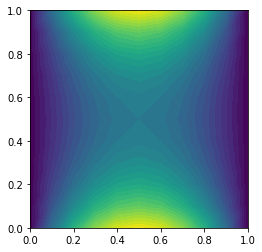

In [40]:
mesh = UnitSquareMesh(10, 10)
V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)
u_prev = Function(V)

#u_prev = interpolate(u_exact, V)  # intital conditions

dt = 0.1
T = 100.

D = Constant(1E-2)

bdy_value = Expression("x[0] * (1-x[0])", degree=2)

## implicit 
a = u * v * dx + dt * D * inner(grad(u), grad(v)) * dx
L = u_prev * v * dx


bcs = [DirichletBC(V, bdy_value, "on_boundary")]

u = Function(V)
t = 0
while t <= T:
    t += dt
    u_exact.t = t
    solve(a==L, u, bcs)
    u_prev.assign(u)
    
plot(u)
